<a href="https://colab.research.google.com/github/raym26/covid_by_county_EDA/blob/master/Covid_by_county_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**An Simple EDA on Covid**

With so much data of Covid available, I decided to build a simple dashboard using R -- partly to reacquaint myself with R and partly for my own sanity. The EDA is almost purely on cases.  I may later on create a more elaborate dashboard that might include deaths or incorporate other datasets.  But that's a project for another day.  

In [17]:
install.packages('usmap')
install.packages('ggrepel')
install.packages('maps')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



I originally wrote this in Rstudio.  But i wanted to try Colab.  For some reason, I had a hard time installing some packages -- tidycensus for example.  Which would have been helpful to view cases with county population as a filter.  

In [18]:
library(tidyverse)
library(usmap)
#library(tidycensus)
library(ggrepel)
library(maps)


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map





The source of county data is from the Times.  

In [7]:
covidfile <- "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

cov <- read.csv(covidfile, header = T)

head(cov)

,date,county,state,fips,cases,deaths
,<fct>,<fct>,<fct>,<int>,<int>,<int>
1,2020-01-21,Snohomish,Washington,53061,1,0
2,2020-01-22,Snohomish,Washington,53061,1,0
3,2020-01-23,Snohomish,Washington,53061,1,0
4,2020-01-24,Cook,Illinois,17031,1,0
5,2020-01-24,Snohomish,Washington,53061,1,0
6,2020-01-25,Orange,California,6059,1,0


Since i live in Cali...

In [9]:
st <- "California"

covid_county <- cov %>% filter(state == st ) %>% mutate(county = tolower(county)) %>% select(-state, -fips)
covid_county$date <- as.Date(covid_county$date)
covid_county <- covid_county %>% group_by(date, county) %>% summarise(total_cases = sum(cases))

head(covid_county)


date,county,total_cases
<date>,<chr>,<int>
2020-01-25,orange,1
2020-01-26,los angeles,1
2020-01-26,orange,1
2020-01-27,los angeles,1
2020-01-27,orange,1
2020-01-28,los angeles,1


The following cell is to filter to the top counties for more easily readable plots.   

In [33]:
covid_county_top <- covid_county %>% filter(date==last(covid_county$date)) %>% arrange(desc(total_cases)) %>%
  top_n(16, total_cases)
top_counties <- covid_county_top$county
top_counties

[1] "los angeles"    "riverside"      "san diego"      "orange"        
 [5] "san bernardino" "santa clara"    "alameda"        "san francisco" 
 [9] "san mateo"      "santa barbara"  "kern"           "tulare"        
[13] "sacramento"     "contra costa"   "fresno"         "ventura"

i'm having formatting issues.  I wanted the labels to the far right.  Viewing panel is also a little too small for the level of detail i have on the plots so not ideal.

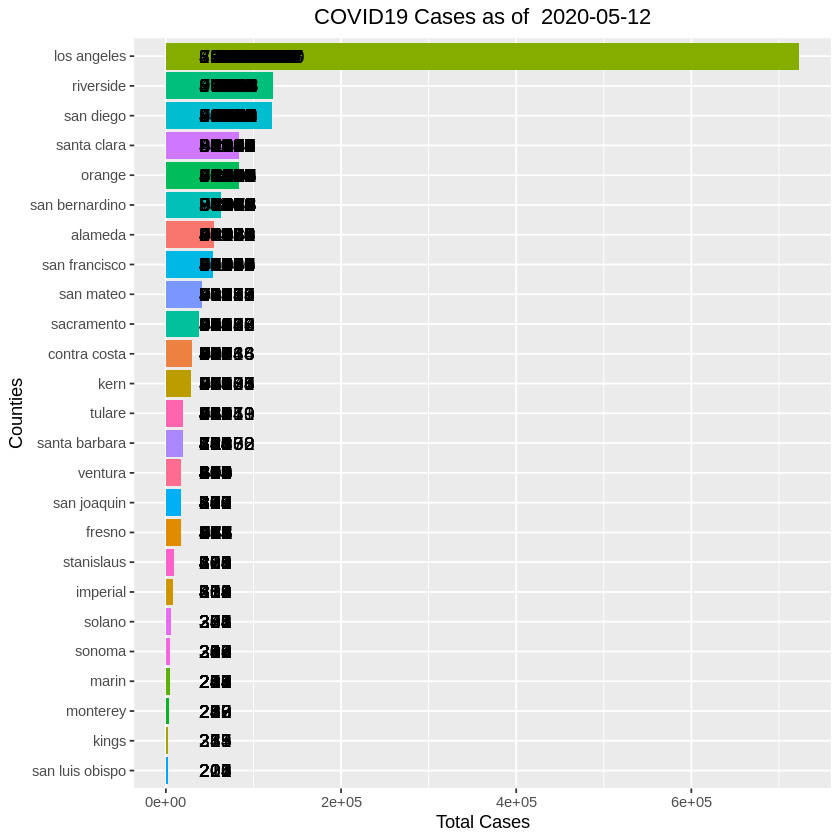

In [45]:
covid_county %>% filter(date==last(date)) %>% filter(total_cases>200) %>% 
  ggplot(aes(x = reorder(county,total_cases, FUN = sum), y = total_cases, fill = county)) + 
  geom_bar(stat = 'identity') + coord_flip() + 
  geom_text(aes(label=total_cases), position=position_dodge(width=.9), hjust = -1, vjust=.5, size = 4) +
  ggtitle(paste("COVID19 Cases as of ", last(covid_county$date))) + xlab("Counties") + ylab("Total Cases") +
  theme(legend.position = "none", plot.title = element_text(hjust = 0.5)) 

Here we zoom out and see where the hotspots are.  Incidentally, i draw a lot of inspiration from viz that's already in circulation.  this is one example of that.  

[1] "date"        "county"      "total_cases" "long"        "lat"

Warning message:
“Setting row names on a tibble is deprecated.”


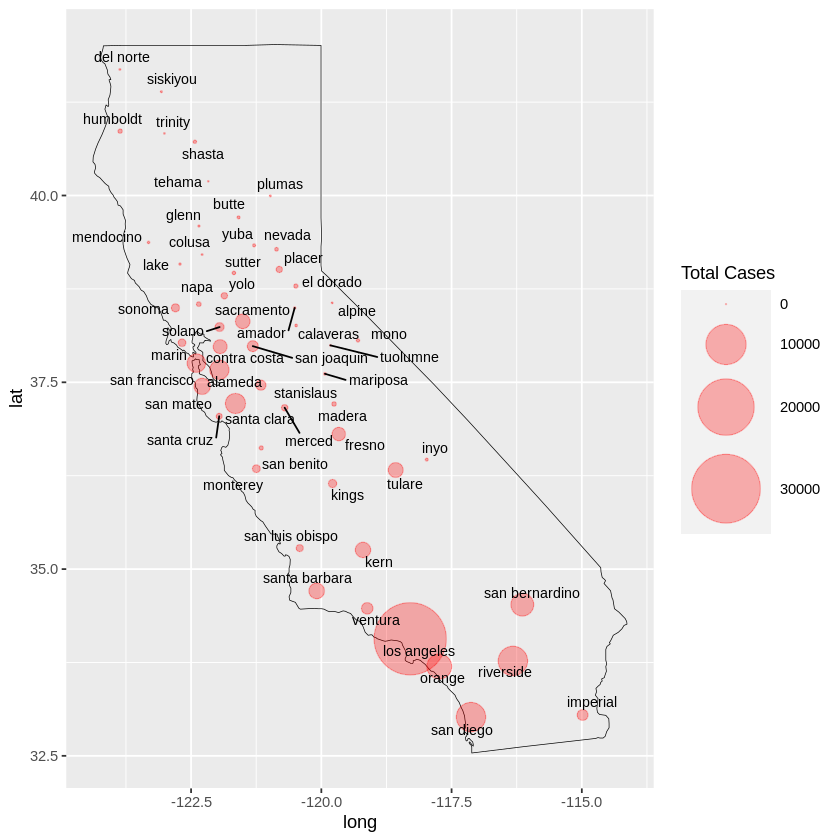

In [20]:
d <- Sys.Date()-1
county_data <- map_data("county") %>% filter(region == "california") %>%  #from maps package
  mutate(county = subregion) %>% select(-6)

options(digits = 10)
county_data  <- county_data %>% group_by(county) %>% 
  summarise(long = as.numeric(mean(long),4), lat = as.numeric(mean(lat),4))

cov_CA_today <- covid_county %>% left_join(county_data, by = 'county') %>% filter(date == d)

CA_outline <- map_data("state") %>% filter(region == 'california')

names(cov_CA_today)
cov_CA_today_lab <- cov_CA_today
rownames(cov_CA_today_lab) <- cov_CA_today_lab$county

cov_CA_today_lab %>% ggplot(aes(long, lat))  + 
  geom_polygon(data=CA_outline, 
               aes(x=long, y=lat, group=group), fill="light grey", col = 'black',size = 0.2) +
  geom_point(aes(long, lat, size = total_cases), col = 'red', inherit.aes = F, alpha =.3) + 
  scale_size_area(max_size = 20, name = "Total Cases", limits = c(0,max(cov_CA_today$total_cases))) +
  geom_text_repel(aes(label = rownames(cov_CA_today_lab)),size = 3)

As you can see the LA county is the hotspot.  No surpise given its population and density.  Generally, socal is doing much worse than norcal even if you take into account pop and density numbers.   This is evident in the next viz.  I took out LA so trend lines for the other counties are more legible.  Anyway, check out Riverside, San Diego, and Orange.    


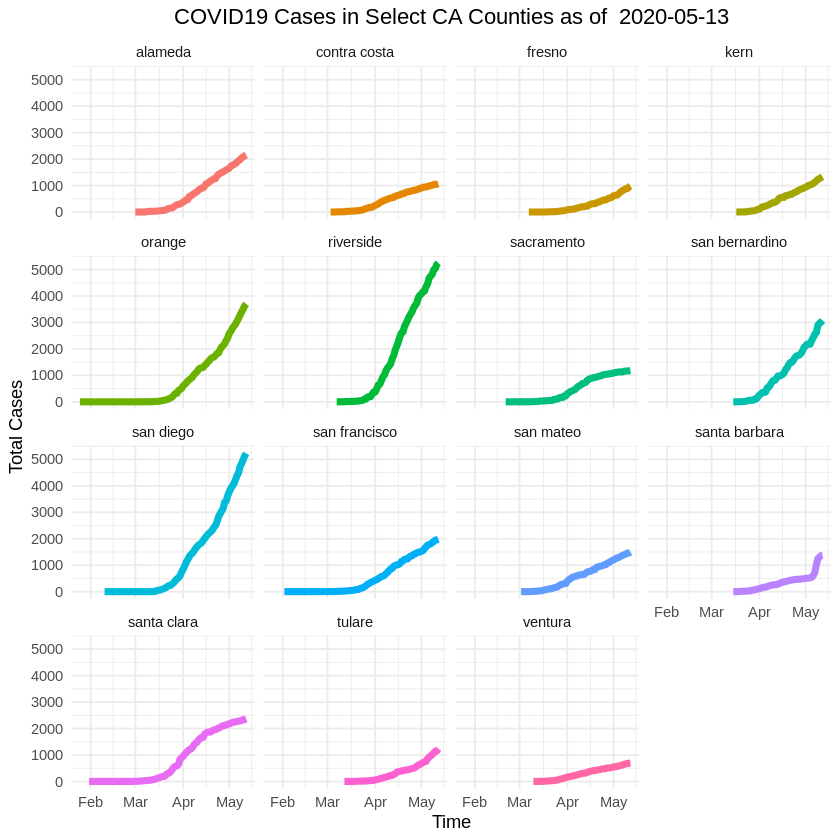

In [34]:
covid_county %>% filter(county %in% top_counties) %>% filter(county != 'los angeles') %>%
  ggplot(aes(date, total_cases, col = county)) + geom_line(size = 2,show.legend = F) +
  facet_wrap(.~county) +  #scales = 'free_y'
  theme_minimal() +
  ggtitle(paste("COVID19 Cases in Select CA Counties as of ", Sys.Date())) + xlab("Time") + ylab("Total Cases") +
  theme(legend.position = "none", plot.title = element_text(hjust = 0.5))  

I also decided to look at little more closely at the top counties, specifically the daily reported cases.  the relatve height of the bars is important here since it's a good indicator of how fast Covid is spreading (i'm assuming away test availability).

I added a fitted line as an visual aid.  And here you see some counties trending in the wrong direction.  


`geom_smooth()` using method = 'loess'



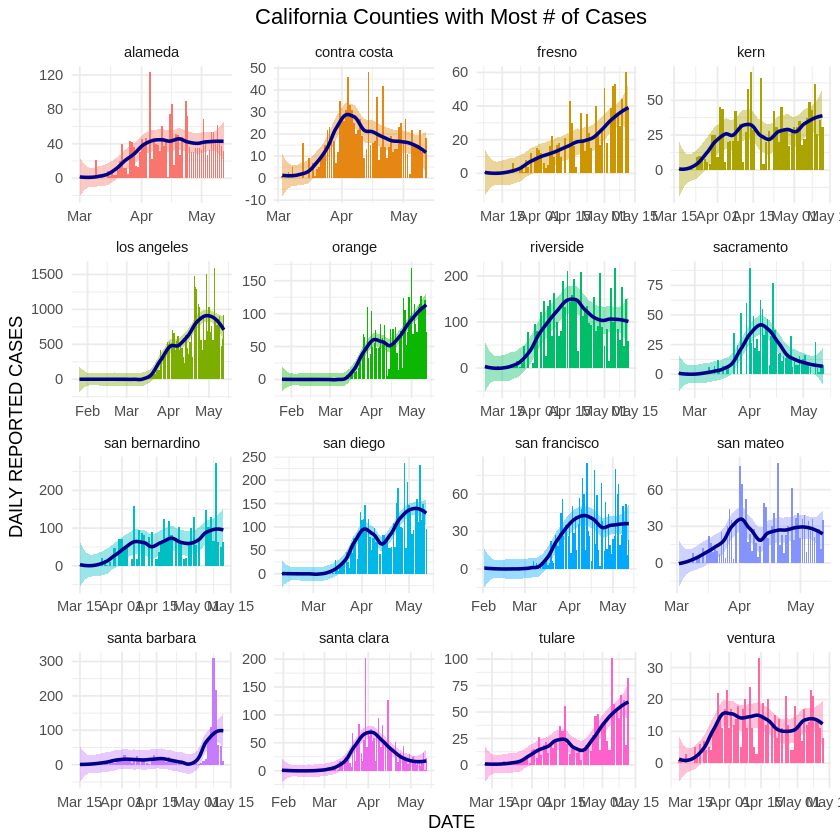

In [35]:
covid_county_daily_ch <- covid_county %>% 
  arrange(county) %>% 
  group_by(county) %>%
  mutate(total_cases = total_cases, day_change = total_cases - lag(total_cases, default = 0))

#geom_bar

covid_county_daily_ch %>% filter(county %in% top_counties) %>%
  ggplot(aes(date, day_change, fill = county)) + geom_bar(stat = 'identity') +
  facet_wrap(~county, scales = 'free') +
  theme_minimal() +
  ggtitle(paste(st,"Counties with Most # of Cases")) +
  geom_smooth(method = 'auto',formula = y~x, span = .4,col = 'darkblue') +
  ylab("DAILY REPORTED CASES") + xlab("DATE") +
  theme(legend.position = "none", plot.title = element_text(hjust = 0.5))
  #geom_line(aes(y = rollmean(day_change, 5, na.pad = T), col = 'red'))
  #stat_summary(fun.y=mean, geom="line", color="red")

Here, I wanted to see all the top counties side by side and compared against a 2x over y days trend.  Earlier, the curves were closer to the 2x over 3 days.  The good news is that overall, the spread amb number of cases has slowed down.  But this is far from over...stay tuned

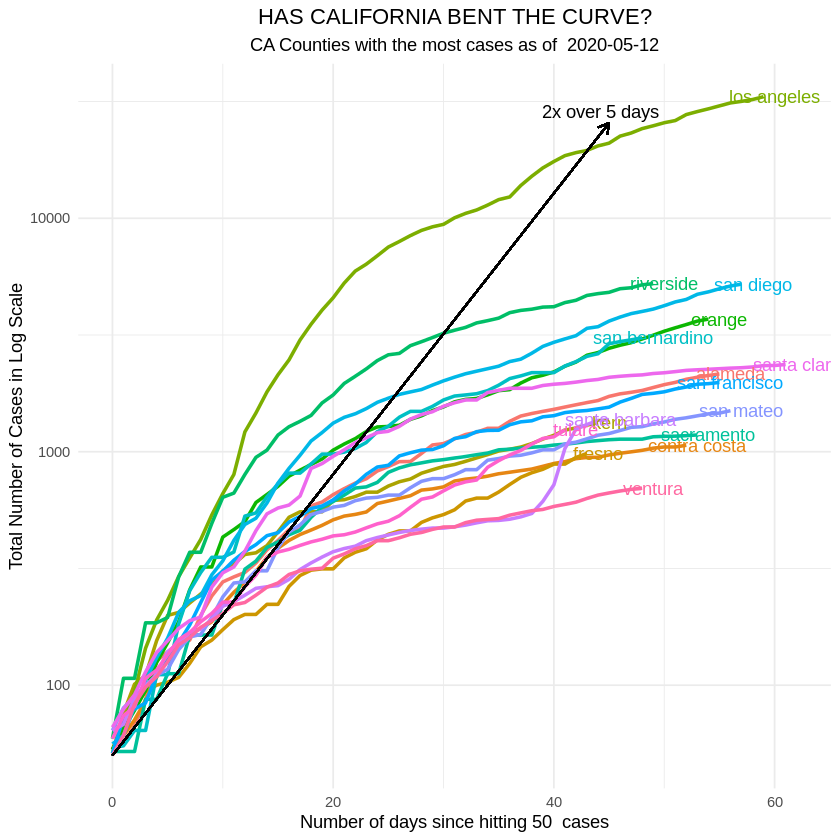

In [51]:
starting_pt = 50

cov_CA_same_top <- covid_county %>% filter(county %in% top_counties) %>%
  filter(total_cases >= starting_pt) %>% group_by(county) %>% 
  mutate(daynum = seq(from=0, to=n()-1))

cov_CA_same_top %>%  
  ggplot(aes(daynum, total_cases, col = county)) + geom_line(size = 1,show.legend = F) +
  geom_text(data = cov_CA_same_top %>% filter(daynum == last(daynum)), 
            aes(label = county, x = daynum + 1, y = total_cases, color = county)) +
  theme_minimal() +
  theme(legend.position = "none", plot.title = element_text(hjust = 0.5), 
        plot.subtitle = element_text(hjust = 0.5)) +
  labs(title = "HAS CALIFORNIA BENT THE CURVE?",
       subtitle = paste("CA Counties with the most cases as of ", tail(cov_CA_same_top$date)),
       x = paste("Number of days since hitting", starting_pt, " cases"), 
       y = "Total Number of Cases in Log Scale") +
  geom_segment(aes(x=0, y=starting_pt, xend = 45, yend = 25600), col = "black", #36 162549
               arrow = arrow(length = unit(.1, 'inches'))) +
  annotate("text", x = 40, y = 28600, label = "2x over 5 days", hjust = .1) +
  scale_y_continuous(trans = 'log10')